In [66]:
import numpy as np
import os
import torch
from matplotlib import pyplot as plt

In [67]:
dataset_folder = 'datasets/'
files = os.listdir(dataset_folder)
files = [f for f in files if f.endswith('.npz')]

In [136]:
for file in files[:3]:
    dataset = np.load(os.path.join(dataset_folder, file))
    print(f"File: {file}")
    Xtr = dataset['Xtr']
    Str = dataset['Str']
    Xts = dataset['Xts']
    Yts = dataset['Yts']
    print(f"{Xtr.shape=}, {Str.shape=}, {Xts.shape=}, {Yts.shape=}")
    print(f"Unique training labels: {np.unique(Str, return_counts=True)}")
    print(f"Unique test labels: {np.unique(Yts, return_counts=True)}")
    print(f"Min/Max training data: {np.min(Xtr), np.max(Xtr)}")
    print(f"Min/Max test data: {np.min(Xts), np.max(Xts)}")
    print("=" * 40)

File: FashionMNIST0.6.npz
Xtr.shape=(18000, 784), Str.shape=(18000,), Xts.shape=(3000, 784), Yts.shape=(3000,)
Unique training labels: (array([0, 1, 2], dtype=uint8), array([5918, 5970, 6112]))
Unique test labels: (array([0, 1, 2], dtype=uint8), array([1000, 1000, 1000]))
Min/Max training data: (0, 255)
Min/Max test data: (0, 255)
File: FashionMNIST0.3.npz
Xtr.shape=(18000, 784), Str.shape=(18000,), Xts.shape=(3000, 784), Yts.shape=(3000,)
Unique training labels: (array([0, 1, 2], dtype=uint8), array([6092, 5930, 5978]))
Unique test labels: (array([0, 1, 2], dtype=uint8), array([1000, 1000, 1000]))
Min/Max training data: (0, 255)
Min/Max test data: (0, 255)
File: CIFAR.npz
Xtr.shape=(15000, 32, 32, 3), Str.shape=(15000,), Xts.shape=(3000, 32, 32, 3), Yts.shape=(3000,)
Unique training labels: (array([0, 1, 2]), array([5000, 5000, 5000]))
Unique test labels: (array([0, 1, 2]), array([1000, 1000, 1000]))
Min/Max training data: (0, 255)
Min/Max test data: (0, 255)


In [137]:
transition_matrices = {
    'FashionMNIST0.3.npz': np.array([
        [0.7, 0.3, 0.0],
        [0.0, 0.7, 0.3],
        [0.3, 0.0, 0.7]
    ]),
    'FashionMNIST0.6.npz': np.array([
        [0.4, 0.3, 0.3],
        [0.3, 0.4, 0.3],
        [0.3, 0.3, 0.4]
    ]),
}

In [138]:
use_transition_matrix = True  # Set to False to ignore the transition matrix
if file == 'CIFAR.npz':
    use_transition_matrix = False
    Xtr = Xtr.reshape(Xtr.shape[0], -1)
    Xts = Xts.reshape(Xts.shape[0], -1)

predict_transition_matrix = True  # Set to True to learn the transition matrix
if predict_transition_matrix:
    use_transition_matrix = False

Xtr = Xtr / 255.0
Xts = Xts / 255.0



n = Xtr.shape[0]
validation_ratio = 0.2
n_val = int(n * validation_ratio)
indices = np.random.permutation(n)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

X_train_tensor = torch.tensor(Xtr[train_indices], dtype=torch.float32)
S_train_tensor = torch.tensor(Str[train_indices], dtype=torch.long)
X_val_tensor = torch.tensor(Xtr[val_indices], dtype=torch.float32)
S_val_tensor = torch.tensor(Str[val_indices], dtype=torch.long)


#one-hot encoding

S_train_tensor = torch.nn.functional.one_hot(S_train_tensor, num_classes=3).float()
S_val_tensor = torch.nn.functional.one_hot(S_val_tensor, num_classes=3).float()


if use_transition_matrix:
    transition_matrix = transition_matrices[file]
    transition_matrix_tensor = torch.tensor(transition_matrix, dtype=torch.float32, requires_grad=True)

In [139]:
X_train_tensor.shape, S_train_tensor.shape, X_val_tensor.shape, S_val_tensor.shape

(torch.Size([12000, 3072]),
 torch.Size([12000, 3]),
 torch.Size([3000, 3072]),
 torch.Size([3000, 3]))

In [180]:

# layer_sizes = [32, 64, 32]
layer_sizes = [256, 128, 64]
layers = []
input_size = Xtr.shape[1]
for size in layer_sizes:
    layers.append(torch.nn.Linear(input_size, size))
    layers.append(torch.nn.LayerNorm(size))
    layers.append(torch.nn.ReLU())
    input_size = size
layers.append(torch.nn.Linear(input_size, 3))
layers.append(torch.nn.Softmax(dim=1))
model = torch.nn.Sequential(*layers)

criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4)
num_epochs = 50
batch_size = 8192
train_losses = []
val_losses = []
val_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.shape[0])
    for i in range(0, X_train_tensor.shape[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_s = X_train_tensor[indices], S_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        if use_transition_matrix:
            outputs = torch.matmul(outputs, transition_matrix_tensor)
        loss = criterion(outputs, batch_s)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        if use_transition_matrix:
            val_outputs = torch.matmul(val_outputs, transition_matrix_tensor)
        val_loss = criterion(val_outputs, S_val_tensor)
        _, predicted = torch.max(val_outputs, 1)
        accuracy = (predicted == S_val_tensor.argmax(dim=1)).float().mean()
        
        test_outputs = model(torch.tensor(Xts, dtype=torch.float32))
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = (test_predicted.numpy() == Yts).mean()
        test_accuracies.append(test_accuracy)
        
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(accuracy.item())
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy.item():.4f}, Test Acc: {test_accuracy:.4f}")

Epoch 1/50, Loss: 1.0996, Val Loss: 1.0990, Val Acc: 0.3490, Test Acc: 0.4233
Epoch 10/50, Loss: 1.0924, Val Loss: 1.0949, Val Acc: 0.3620, Test Acc: 0.5373
Epoch 20/50, Loss: 1.0894, Val Loss: 1.0945, Val Acc: 0.3533, Test Acc: 0.5793
Epoch 30/50, Loss: 1.0836, Val Loss: 1.0945, Val Acc: 0.3607, Test Acc: 0.5873
Epoch 40/50, Loss: 1.0795, Val Loss: 1.0953, Val Acc: 0.3560, Test Acc: 0.5927
Epoch 50/50, Loss: 1.0765, Val Loss: 1.0960, Val Acc: 0.3627, Test Acc: 0.5870


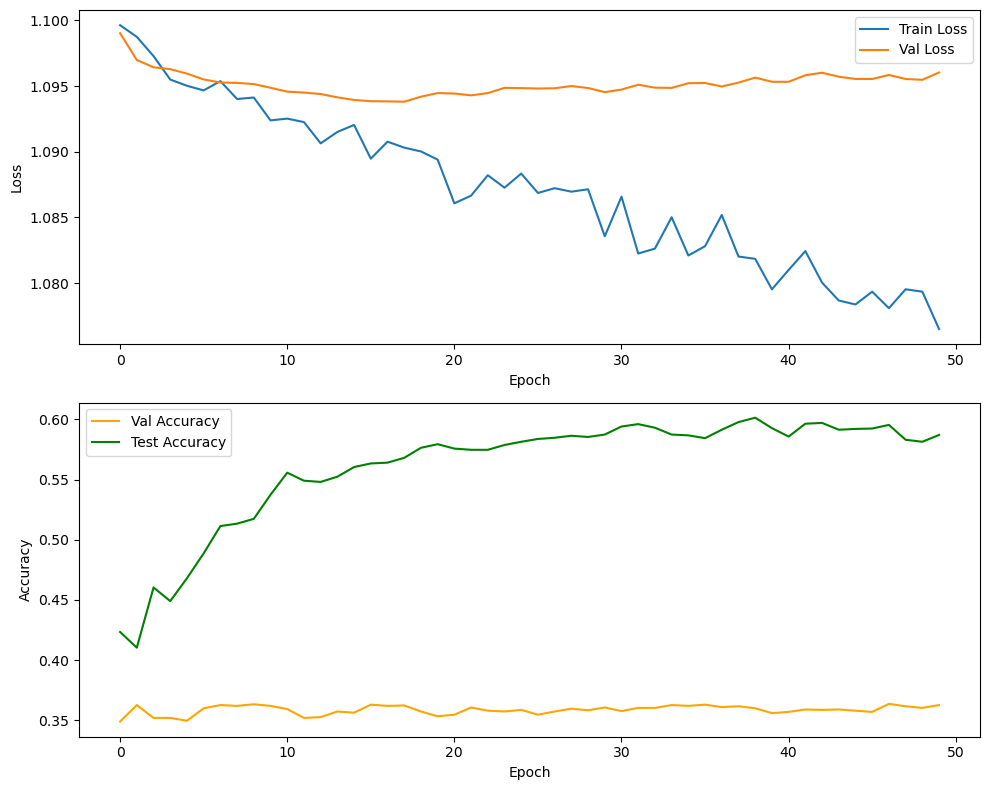

In [181]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(val_accuracies, label='Val Accuracy', color='orange')
axs[1].plot(test_accuracies, label='Test Accuracy', color='green')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

In [75]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train_tensor)
    _, y_pred_classes = torch.max(y_pred, 1)

y_pred = y_pred.numpy()
y_pred_classes = y_pred_classes.numpy()

In [76]:
print(file)
print(transition_matrices[file])

FashionMNIST0.3.npz
[[0.7 0.3 0. ]
 [0.  0.7 0.3]
 [0.3 0.  0.7]]


In [77]:
matrix = np.zeros((3, 3))
for column in range(3):

    highest_confidence_pred_index = y_pred[y_pred_classes == column][:, column].argmax()
    highest_confidence_pred = y_pred[y_pred_classes == column][highest_confidence_pred_index]
    # print(highest_confidence_pred_index, highest_confidence_pred)
    matrix[column] = highest_confidence_pred


In [78]:
matrix

array([[0.71131712, 0.11539292, 0.17329001],
       [0.11271949, 0.74507904, 0.14220148],
       [0.13254231, 0.14864558, 0.71881205]])